# Importing necessary libraries

In [1]:
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

import sklearn

from sklearn import linear_model
from sklearn import decomposition
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from smt.sampling_methods import LHS

import time
import datetime
import random
import csv
import os
import copy
import json
from tqdm import tqdm



/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
with open('data_X_SMW_LHS_uniform_4000.txt', 'r') as f:
    SMW_data=json.load(f)

with open('data_X_drift_LHS_uniform.txt', 'r') as f:
    drift_data=json.load(f)

with open('data_X_recombination_LHS_uniform.txt', 'r') as f:
    recombination_data=json.load(f)

In [33]:
all_pfm = pd.read_csv('all_pfm.csv')
all_pfm = list(all_pfm["Motif ID"])

def calculate_pocc(pfm: pd.DataFrame, sequence: str) -> float:
    # Initialize the product of the probabilities of not binding
    product_not_binding = 1

    # Get the length of the PFM
    pfm_length = len(pfm.columns)

    # Create a mapping from bases to indices
    base_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    # For each window in the sequence
    for i in range(len(sequence) - pfm_length + 1):
        # Get the window
        window = sequence[i:i+pfm_length]

        # Calculate the probability of binding to the current window (Pi)
        pi = 1
        for j in range(pfm_length):
            # Get the base at position j in the window
            base = window[j]
            # Get the index of the base
            base_index = base_to_index[base]
            # Get the probability of the base at position j
            prob = pfm.loc[base_index, j] 
            # Multiply Pi by the probability
            pi *= prob

        # Update the product of the probabilities of not binding
        product_not_binding *= (1 - pi)

    # Calculate Pocc
    pocc = 1 - product_not_binding

    # Return Pocc
    return pocc


In [34]:
def sum_pocc_sequence(sequences):
    pfm_value = np.zeros(len(sequences))
    for i in range(244):
        pfm_file_path = 'PFM/'+all_pfm[i]+'.pfm'
        pfm_df = pd.read_csv(pfm_file_path, delimiter='\t', skiprows=0,header=None)
        for j in range(len(sequences)):
            pfm_value[j]+=calculate_pocc(pfm_df, sequences[j])    
    return pfm_value

In [35]:
def get_pocc_sequence(sequences):
    pfm_value = np.zeros([len(sequences),244])
    for i in range(244):
        pfm_file_path = 'PFM/'+all_pfm[i]+'.pfm'
        pfm_df = pd.read_csv(pfm_file_path, delimiter='\t', skiprows=0,header=None)
        for j in range(len(sequences)):
            pfm_value[j][i]+=calculate_pocc(pfm_df, sequences[j])    
    return pfm_value

In [15]:
a = [np.mean(get_pocc_sequence(SMW_data[0]), axis=0), np.mean(get_pocc_sequence(SMW_data[1]), axis=0), np.mean(get_pocc_sequence(SMW_data[2]), axis=0), np.mean(get_pocc_sequence(SMW_data[3]), axis=0), np.mean(get_pocc_sequence(SMW_data[4]), axis=0)]
np.savetxt('pocc_SMW.txt', a)
b = [np.mean(get_pocc_sequence(drift_data[0]), axis=0), np.mean(get_pocc_sequence(drift_data[1]), axis=0), np.mean(get_pocc_sequence(drift_data[2]), axis=0), np.mean(get_pocc_sequence(drift_data[3]), axis=0), np.mean(get_pocc_sequence(drift_data[4]), axis=0)]
np.savetxt('pocc_drift.txt', b)
c = [np.mean(get_pocc_sequence(recombination_data[0]), axis=0), np.mean(get_pocc_sequence(recombination_data[1]), axis=0), np.mean(get_pocc_sequence(recombination_data[2]), axis=0), np.mean(get_pocc_sequence(recombination_data[3]), axis=0), np.mean(get_pocc_sequence(recombination_data[4]), axis=0)]
np.savetxt('pocc_recombination.txt', c)

NameError: name 'get_pocc_sequence' is not defined

In [9]:
uniform_pocc = np.loadtxt('pocc_recombination.txt')

In [10]:
np.mean(uniform_pocc, axis=1)

array([0.0037476 , 0.00479925, 0.00505713, 0.00670903, 0.00825638])

/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Min value: -11.168955275815016
Max value: 4.220834214011038


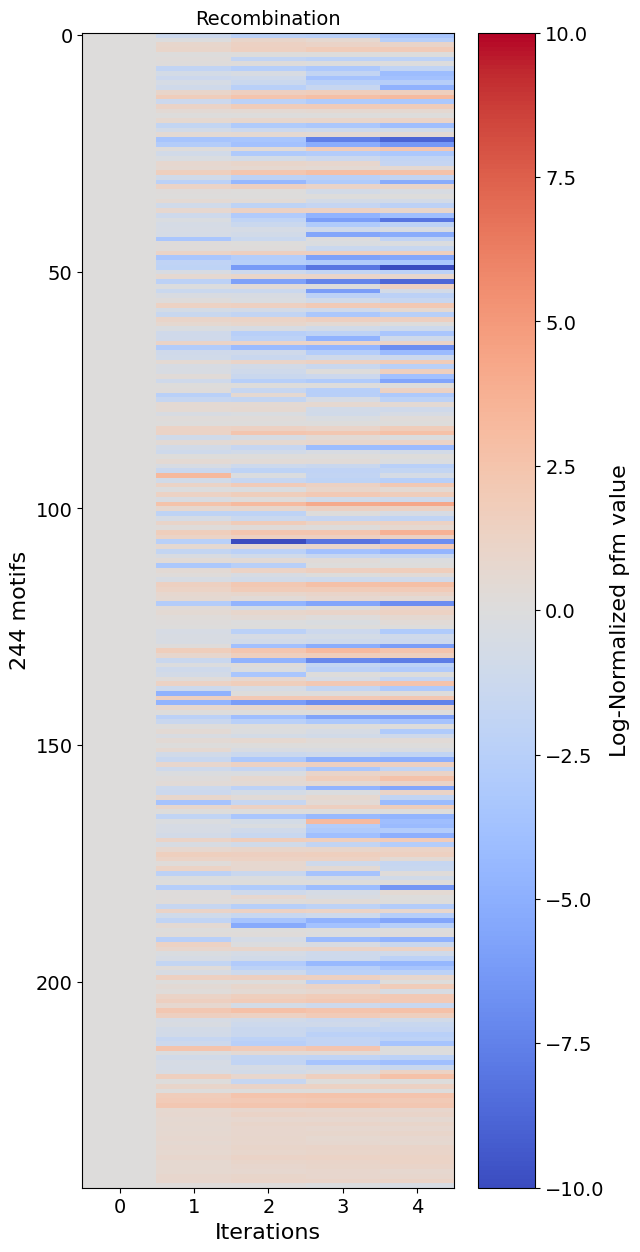

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Replace NaN values with 0 in uniform_pocc
uniform_pocc = np.nan_to_num(uniform_pocc, nan=0)

# Set entire column to 1 if uniform_pocc[0, :] for that column is 0
uniform_pocc[:, uniform_pocc[0, :] == 0] = 1

# Normalize the data: take the first iteration as 1
normalized_uniform_pocc = uniform_pocc / uniform_pocc[0, :]

# Apply log transformation
log_normalized_uniform_pocc = np.log(normalized_uniform_pocc)
log_normalized_uniform_pocc = np.nan_to_num(log_normalized_uniform_pocc, nan=0, posinf=0, neginf=0)

# Debugging: Print min and max values of the data
print("Min value:", log_normalized_uniform_pocc.min())
print("Max value:", log_normalized_uniform_pocc.max())

# Set vmin and vmax to center the colormap around 0
# vmin = -max(abs(log_normalized_uniform_pocc.min()), abs(log_normalized_uniform_pocc.max()))
# vmax = max(abs(log_normalized_uniform_pocc.min()), abs(log_normalized_uniform_pocc.max()))

# # Debugging: Print vmin and vmax
# print("vmin:", vmin)
# print("vmax:", vmax)

# Plot the heatmap
plt.figure(figsize=(6,15))
plt.imshow(log_normalized_uniform_pocc.T, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=-10, vmax=10)
cbar = plt.colorbar(label='Log-Normalized pfm value')
cbar.ax.tick_params(labelsize=14)  # Increase font size for colorbar ticks
cbar.set_label('Log-Normalized pfm value', fontsize=16)  # Increase font size for colorbar label
plt.ylabel('244 motifs'.format(uniform_pocc.shape[1]), fontsize=16)
plt.xlabel('Iterations'.format(uniform_pocc.shape[0]), fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Recombination', fontsize=14)
plt.savefig('pocc_recombination.pdf')
plt.show()